In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import utils

from transformers import T5Tokenizer


class TrainingArgs:
    def __init__(self):
        self.train_data = 'data/train-train_classification_test_classification.json'
        self.val_data = 'data/val-train_classification_test_classification.json'
        self.t5_model = 't5-base'
        self.k = 8

args = TrainingArgs()
tokenizer = T5Tokenizer.from_pretrained(args.t5_model, model_max_length=1024)

In [2]:
def get_examples_df(raw_data, args):
    examples = []
    for task in raw_data:
        for train_example in task['train_examples']:
            demos = utils.sample_demos(task['dev_examples'], args.k, utils.n_label(task['task_name']))
            input_text = utils.create_input_text(demos, train_example[0], 'label:', '. ')
            target = random.choice(train_example[1])  
            examples.append([
                task['task_name'],
                task['task_prefix'],
                input_text,
                target,
                len(tokenizer(input_text)['input_ids']),
                len(tokenizer(target)['input_ids']),
            ])

    return pd.DataFrame(examples, columns=['task_name', 'task_prefix', 'input_text', 'target', 'input_len', 'target_len'])


def print_stat(df):
    print('Num tasks                      : {}'.format(np.unique(df['task_name']).shape[0]))
    print('Num examples                   : {}'.format(df.shape[0]))
    print('Num examples with input > 1024 : {}'.format(df[df['input_len'] > 1024].shape[0]))
    print('Num examples with target > 32  : {}'.format(df[df['target_len'] > 32].shape[0]))
    print('Max input length               : {}'.format(df['input_len'].max()))
    print('Min input length               : {}'.format(df['input_len'].min()))
    print('Max target length              : {}'.format(df['target_len'].max()))
    print('Min target length              : {}'.format(df['target_len'].min()))


def get_num_examples_per_task(df):
    df1 = pd.DataFrame(df.groupby('task_name').size(), columns=['n_examples']).reset_index()
    df2 = df.groupby('task_name')['input_len'].apply(lambda x: (x>1024).sum()).reset_index(name='n_long_input')
    return pd.merge(df1, df2)

In [ ]:
utils.random_seed(0)
train_df = get_examples_df(json.load(open(args.train_data)), args)
val_df = get_examples_df(json.load(open(args.val_data)), args)

# Training set

In [4]:
print_stat(train_df)

Num tasks                      : 44
Num examples                   : 26865
Num examples with input > 1024 : 1155
Num examples with target > 32  : 0
Max input length               : 9916
Min input length               : 110
Max target length              : 10
Min target length              : 2


In [5]:
get_num_examples_per_task(train_df)

,task_name,n_examples,n_long_input
0,ade_corpus_v2-classification,160,0
1,circa,400,0
2,discovery,13920,0
3,emotion,480,0
4,ethos-directed_vs_generalized,160,0
5,ethos-disability,160,0
6,ethos-gender,160,0
7,ethos-sexual_orientation,160,0
8,glue-cola,160,0
9,glue-mnli,240,0


Task: yahoo_answers_topics


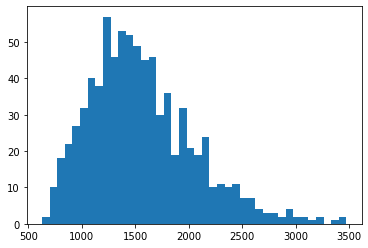

In [6]:
TASK_NAME = 'yahoo_answers_topics'
print('Task: {}'.format(TASK_NAME))
n, bins, patches = plt.hist(train_df[train_df['task_name']==TASK_NAME]['input_len'].values, 40)
plt.show()

# Validation set

In [7]:
print_stat(val_df)

Num tasks                      : 10
Num examples                   : 2240
Num examples with input > 1024 : 72
Num examples with target > 32  : 0
Max input length               : 1587
Min input length               : 149
Max target length              : 5
Min target length              : 2


In [8]:
get_num_examples_per_task(val_df)

,task_name,n_examples,n_long_input
0,ag_news,320,0
1,amazon_polarity,160,72
2,climate_fever,320,0
3,ethos-national_origin,160,0
4,hate_speech18,160,0
5,medical_questions_pairs,160,0
6,poem_sentiment,320,0
7,tweet_eval-hate,160,0
8,tweet_eval-stance_atheism,240,0
9,tweet_eval-stance_feminist,240,0


Task: amazon_polarity


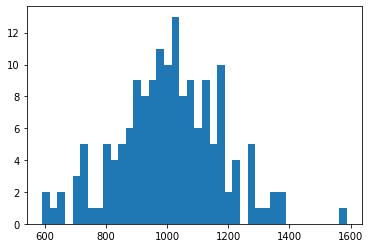

In [9]:
TASK_NAME = 'amazon_polarity'
print('Task: {}'.format(TASK_NAME))
n, bins, patches = plt.hist(val_df[val_df['task_name']==TASK_NAME]['input_len'].values, 40)
plt.show()